In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('data/parsed_chase.csv')
# For easier data manipulation want the chaserWin not playerWin!
df["chaserWin"] = ~df["playerWin"]

df.head()

,Series,Episode,AirDate,Chaser,P1,P2,P3,P4,NPlayers,PTotal,playerScore,chaserScore,playerWin,remainingTime,chaserWin
0,7,1,2013-09-02,Anne Hegerty,3000.0,0.0,0.0,3000.0,2.0,6000.0,14,14,False,47.0,True
1,7,2,2013-09-03,Mark Labbett,7000.0,6000.0,5000.0,42000.0,4.0,60000.0,19,18,True,0.0,False
2,7,3,2013-09-04,Shaun Wallace,1000.0,0.0,0.0,49000.0,2.0,50000.0,17,17,False,2.0,True
3,7,4,2013-09-05,Mark Labbett,0.0,30000.0,-3000.0,7000.0,2.0,34000.0,19,19,False,6.0,True
4,7,5,2013-09-06,Paul Sinha,0.0,0.0,4000.0,5000.0,2.0,9000.0,11,11,False,61.0,True


## Win Rate by Chaser

First we want to visualise the win rates of each chaser, see if there is any variability between them

In [3]:
chasers_group = df[["Chaser","chaserWin"]].groupby("Chaser")
winrate_df = pd.DataFrame()
winrate_df["winRate"] = 100*chasers_group["chaserWin"].sum()/chasers_group["chaserWin"].count()
winrate_df["Chaser"] = chasers_group["chaserWin"].sum().index

# Just so we have an entry for average over all chasers
winrate_df = winrate_df.append({"Chaser": "All", "winRate" : 100*df["chaserWin"].sum()/df["chaserWin"].count()}, ignore_index=True)
#winrate_df[["Chaser", "winRate"]].head(10)
winrate_df.set_index("Chaser").head(10)

,winRate
Chaser,
Anne Hegerty,80.177515
Jenny Ryan,77.483444
Mark Labbett,75.667656
Paul Sinha,75.986842
Shaun Wallace,71.296296
All,75.997249


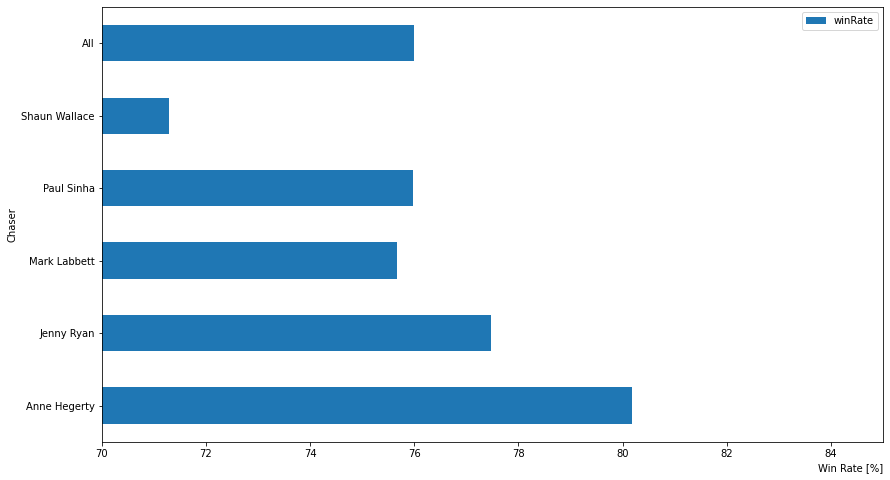

In [4]:
ax = winrate_df.plot(kind='barh', x="Chaser", y="winRate", xlim = [70,85], figsize=(14, 8))
plt.xlabel('Win Rate [%]', horizontalalignment='right', x=1.0)
plt.show()

What we can see is that 76% of episodes result in the chaser winning. The chaser with the highest win rate is Anne Hegerty with 80.2%, with Shaun Wallace falling with the lowest win rate of 71.3%.

So immediately it seems the chaser in the episode could be a useful variable in predicting whether the contestants can win or not.

## Player Wins vs Number of Answered Question

Now let's visualise the wins and losses as a function of player score in the final chase. First let's just see what the distribution of scores actually looks like!

Note: When evaluating win-rates, to note the uncertainties are calculated from binomial variance.

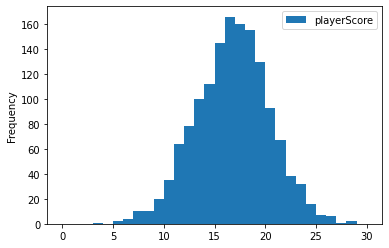

In [92]:
ax = df.plot(kind="hist", y="playerScore", bins=np.linspace(0,30,31))
plt.show()

Okay so most players get a score somewhere between 15 and 20. Let's keep this in mind...

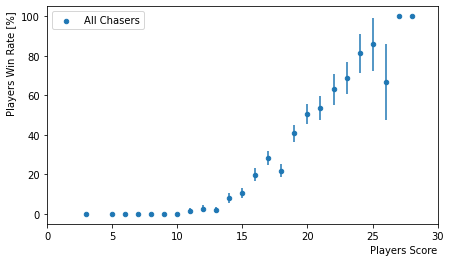

In [99]:
def plot_score_winrates(in_df, label="All Chasers"):
    chasers_group = in_df[["playerScore","playerWin"]].groupby("playerScore")
    winrate_df = pd.DataFrame()
    winrate_df["winRate"] = chasers_group["playerWin"].sum()/chasers_group["playerWin"].count()
    # Using binomial variance
    winrate_df["winRateErr"] = (winrate_df["winRate"]*(1-winrate_df["winRate"])/chasers_group["playerWin"].count())**0.5
    # Map fractions to percents 
    winrate_df["winRate"] = winrate_df["winRate"]*100
    winrate_df["winRateErr"] = winrate_df["winRateErr"]*100

    winrate_df["playerScore"] = chasers_group["playerWin"].sum().index
    ax = winrate_df.plot(kind="scatter", x="playerScore", y="winRate", yerr="winRateErr", figsize=(7, 4),  xlim = [0,30])
    ax.legend([label])
    plt.xlabel('Players Score', horizontalalignment='right', x=1.0)
    plt.ylabel('Players Win Rate [%]', horizontalalignment='left', x=1.0)
    
    plt.show()
    
plot_score_winrates(df)

Generally we see the win-rate below 13 is effectively 0%. Then a general climb up to a win-rate of 100% for a score of above 26. A score of 20 is needed to expect a 50% chance of winning.

Some interesting drops appearing at 18 and 26 (though this is likely just statistics), though not largely significant statistically. This could hint that the chasers change their play style depending on what the player score is... Let's look at this plot but for each chaser individually.

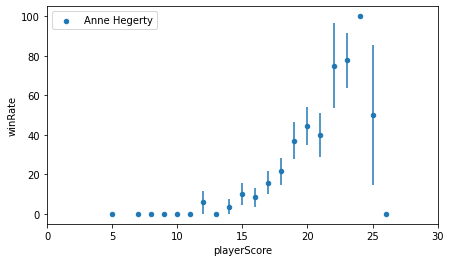

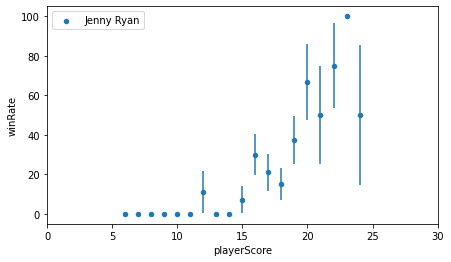

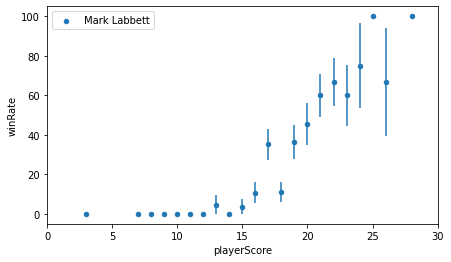

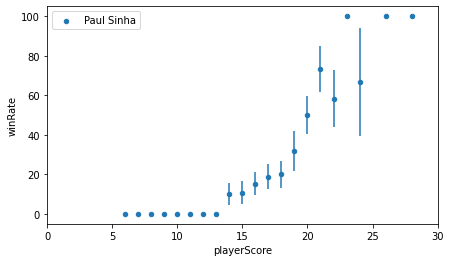

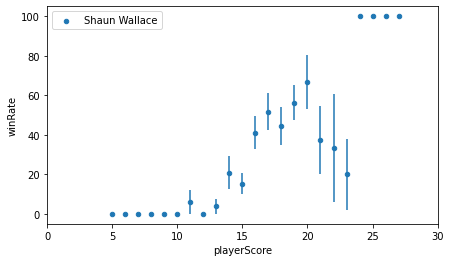

In [94]:
chasers = ["Anne Hegerty", "Jenny Ryan", "Mark Labbett", "Paul Sinha", "Shaun Wallace"]
for c in chasers:
    plot_score_winrates(df[df["Chaser"] == c], label=c)

Producing this plot for each chaser some interesting results. This dip at 18 seems to be strongly influenced by Mark Labbett, and mildly also by Jenny Ryan. It is however only ~2sigma so not something to read into too much.

We also see Shaun Wallace has a distribution that differs from the others, at 21-23 the player win-rates are curiously lower than the others, but for the bulk region 15-20 the players have a much stronger chance of winning in comparison with other chasers.